In [9]:
import os

from openai import AzureOpenAI
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version="2023-12-01-preview",
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    )


def generate_embeddings(text, model="text-embedding-ada-002"): 
    return client.embeddings.create(input = [text], model=model).data[0].embedding


def calculate_and_plot(sentences, filename=None):
    # calculate embeddings for all combinations of the sentences
    embeddings = [generate_embeddings(s) for s in sentences]

    # calculate cosine similarity for all combinations of the sentences
    similarity = cosine_similarity(embeddings, embeddings)

    # label the rows and columns with the sentences
    similarity = pd.DataFrame(similarity, columns=sentences, index=sentences)
    
    # plot the similarity matrix as a triangle
    mask = np.triu(np.ones_like(similarity, dtype=bool))
    sns.heatmap(similarity, cmap="Blues", annot=True, mask=mask)
    if filename:
        plt.savefig(filename+".png", bbox_inches="tight")
    plt.show()

def calculate_and_short(question, options):
    embedding_for_question = generate_embeddings(question)
    embeddings_for_options = [generate_embeddings(option) for option in options]

    # calculate cosine similarity for the question and all options
    similarity = cosine_similarity([embedding_for_question], embeddings_for_options)
    
    # label the rows and columns with the sentences
    similarity = pd.DataFrame(similarity, columns=options, index=[question])

    # short by similarity
    similarity = similarity.T.sort_values(by=question, ascending=False)

    display(similarity)


## Embedding

An embedding is a way to represent discrete items, such as words, sentences or even entire documents in a continuous vector space. 

In practical terms, an embedding represents a list of words as a vector of real numbers.

How many numbers? It depends of the technology used. The commonly used text-embedding-ada-002 uses 1536 numbers.



In [13]:
embedding_for_cat = generate_embeddings("Cat")
print(embedding_for_cat)
print(len(embedding_for_cat))

[-0.008119281381368637, -0.007456901017576456, -0.009771818295121193, -0.024842679500579834, -0.012776429764926434, 0.006579417735338211, -0.0015347421867772937, -0.03783079981803894, -0.01431287918239832, -0.026304014027118683, 0.01708531752228737, 0.046134453266859055, 0.003605534555390477, 0.004278157837688923, -0.0321766659617424, -0.004527403973042965, 0.039469677954912186, 0.00512491213157773, 0.007825648412108421, -0.01563763990998268, -0.023599863052368164, 0.005370744038373232, 0.01494111679494381, -0.011929675936698914, -0.006825249642133713, 0.004486432299017906, 0.012312080711126328, -0.01342515368014574, 0.005555117968469858, 0.0009073587134480476, 0.009819618426263332, -0.016579996794462204, -0.017822813242673874, -0.03919653221964836, -0.029390569776296616, -0.00035786465741693974, 0.011390211060643196, -0.0073886145837605, 0.02059525065124035, -0.013930474407970905, 0.009539643302559853, 0.009771818295121193, -0.013404667377471924, 0.01183407474309206, -0.00251806993037

In [14]:
embedding_for_supercat = generate_embeddings("I like cts, they are much better than dogs")
print(embedding_for_cat)
print(len(embedding_for_supercat))

[-0.008119281381368637, -0.007456901017576456, -0.009771818295121193, -0.024842679500579834, -0.012776429764926434, 0.006579417735338211, -0.0015347421867772937, -0.03783079981803894, -0.01431287918239832, -0.026304014027118683, 0.01708531752228737, 0.046134453266859055, 0.003605534555390477, 0.004278157837688923, -0.0321766659617424, -0.004527403973042965, 0.039469677954912186, 0.00512491213157773, 0.007825648412108421, -0.01563763990998268, -0.023599863052368164, 0.005370744038373232, 0.01494111679494381, -0.011929675936698914, -0.006825249642133713, 0.004486432299017906, 0.012312080711126328, -0.01342515368014574, 0.005555117968469858, 0.0009073587134480476, 0.009819618426263332, -0.016579996794462204, -0.017822813242673874, -0.03919653221964836, -0.029390569776296616, -0.00035786465741693974, 0.011390211060643196, -0.0073886145837605, 0.02059525065124035, -0.013930474407970905, 0.009539643302559853, 0.009771818295121193, -0.013404667377471924, 0.01183407474309206, -0.00251806993037

**What the numbers represents?**
No one knows. It is a black box.

**Why similar concepts have similar (close in distance) vectors?**
It is a consequence of the underlying technology

**Where this embeddings come from?**
Hidden layers in a neural network



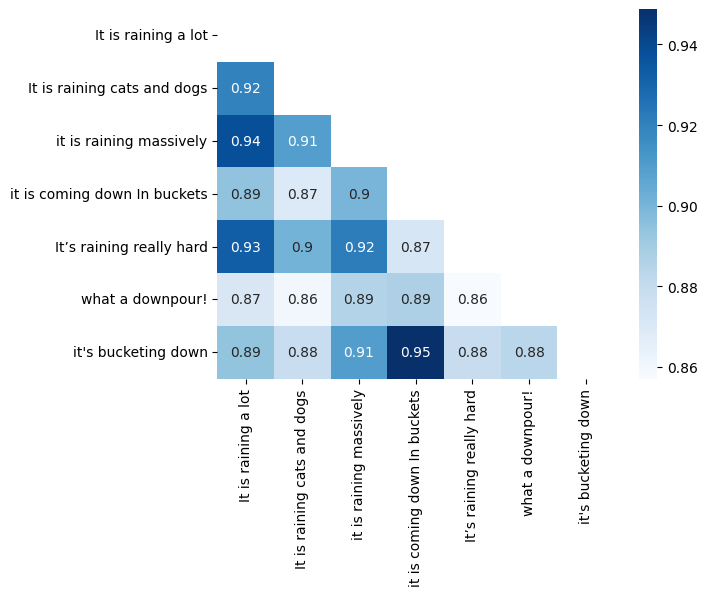

In [10]:
calculate_and_plot(["It is raining a lot", 
                    "It is raining cats and dogs", 
                    "it is raining massively", 
                    "it is coming down In buckets",
                    "It’s raining really hard",
                    "what a downpour!",
                    "it's bucketing down"])